
# Objective




A tabela data_clientes, possui as informações de cada usuário do banco com uma classificação pré-estabelecida para esses usuários.  A classificação é dada A,B,C,D ou F, sendo que de A a D é como o cliente utiliza sua conta de maneira boa a ruim e F se é uma conta fraudulenta. Algumas contas não estão classificadas.

Como objetivo, sera criado um modelo que possa aprender com os dados e possa dizer se essas contas que não possuem classificação são ou não fraude. 

O resultado será um csv com 2 colunas. 1ª 'account_number' conta do cliente, 2ª 'fraud' com 0 para não fraude e 1 para fraude. 







# Description

*   data_clientes -> dados do cliente
*   data_transactions -> transações de cada cliente. Transações do tipo 1 (boleto recebido), tipo 2 (pix enviado), tipo 3 (pix recebido)
*   data_charges -> Boletos pagos ou não pagos por cada cliente

## Importing Libraries

In [ ]:
# Bibliotecas utilizadas
import pandas as pd
import numpy as np
from datetime import datetime, date
import statistics
import warnings
warnings.filterwarnings('ignore')

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-Processamento 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from category_encoders.one_hot import OneHotEncoder

# Criação dos Modelos
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Validação dos Modelos
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

## Loading Data

In [ ]:
data_charges = pd.read_csv('data_charges.csv')

In [ ]:
data_transaction = pd.read_csv('data_transaction.csv')

In [ ]:
data_clientes = pd.read_csv('data_clientes.csv')

# Pre-Processing

## Data View

### Client's data

In [ ]:
data_clientes.head()

,id,account_number,birth,occupation,address_id,created_at,id.1,state,city,created_at.1,id.2,level,created_at.2
0,1,155938,1984-10-29,Outros,1,2021-04-01 02:30:00,1,RJ,Carmo,2021-04-01 02:30:00,1.0,F,2021-04-20 08:00:00
1,2,747007,1977-03-26,Corretor,2,2021-04-01 02:00:00,2,MG,Bertopolis,2021-04-01 02:00:00,2.0,D,2021-04-19 19:30:00
2,3,208404,1984-01-26,Analista,3,2021-04-01 11:30:00,3,MG,Olaria,2021-04-01 11:30:00,NaN,NaN,NaN
3,4,66402,1982-06-30,Investidor,4,2021-04-01 14:30:00,4,PR,Icaraima,2021-04-01 14:30:00,4.0,D,2021-04-28 21:00:00
4,5,277012,1967-01-11,Outros,5,2021-04-02 15:30:00,5,ES,Ecoporanga,2021-04-02 15:30:00,5.0,D,2021-04-19 12:00:00


In [ ]:
'''
Existência de dados do tipo quantitativo e qualitativo no dataframe data_clientes
'''

data_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1029 non-null   int64  
 1   account_number  1029 non-null   int64  
 2   birth           1029 non-null   object 
 3   occupation      1029 non-null   object 
 4   address_id      1029 non-null   int64  
 5   created_at      1029 non-null   object 
 6   id.1            1029 non-null   int64  
 7   state           1029 non-null   object 
 8   city            1029 non-null   object 
 9   created_at.1    1029 non-null   object 
 10  id.2            926 non-null    float64
 11  level           926 non-null    object 
 12  created_at.2    926 non-null    object 
dtypes: float64(1), int64(4), object(8)
memory usage: 104.6+ KB


In [ ]:
'''
103 valores NAs existentes
'''
data_clientes.isna().sum()

id                  0
account_number      0
birth               0
occupation          0
address_id          0
created_at          0
id.1                0
state               0
city                0
created_at.1        0
id.2              103
level             103
created_at.2      103
dtype: int64

### Charges

In [ ]:
data_charges.head()

,id,account_number,status,value,created_at
0,1,155938,paid,11992,2021-04-01 03:00:00
1,2,155938,paid,9689,2021-04-01 13:30:00
2,3,155938,paid,11579,2021-04-01 11:30:00
3,4,747007,unpaid,3134,2021-04-02 12:00:00
4,5,747007,paid,3085,2021-04-02 19:00:00


In [ ]:
'''
Verificado a existência de 154469 registros com informações quantitativas e qualitativas
'''
data_charges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154469 entries, 0 to 154468
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              154469 non-null  int64 
 1   account_number  154469 non-null  int64 
 2   status          154469 non-null  object
 3   value           154469 non-null  int64 
 4   created_at      154469 non-null  object
dtypes: int64(3), object(2)
memory usage: 5.9+ MB


In [ ]:
'''
Inexistência de valores faltantes 
'''
data_charges.isna().sum()

id                0
account_number    0
status            0
value             0
created_at        0
dtype: int64

### Transactions

In [ ]:
data_transaction.head()

,id,account_number,transaction_type_id,value,created_at
0,1,155938,1,11992,2021-04-01 03:00:00
1,2,155938,1,9689,2021-04-01 13:30:00
2,3,155938,1,11579,2021-04-01 11:30:00
3,4,155938,3,11168,2021-04-01 11:00:00
4,5,155938,3,10772,2021-04-01 21:00:00


In [ ]:
'''
Existência de 256227 registros com informações quantitativas e qualitativas em formatos int e object
'''
data_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256227 entries, 0 to 256226
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id                   256227 non-null  int64 
 1   account_number       256227 non-null  int64 
 2   transaction_type_id  256227 non-null  int64 
 3   value                256227 non-null  int64 
 4   created_at           256227 non-null  object
dtypes: int64(4), object(1)
memory usage: 9.8+ MB


In [ ]:
'''
Inexistência de valores faltantes 
'''
data_transaction.isna().sum()

id                     0
account_number         0
transaction_type_id    0
value                  0
created_at             0
dtype: int64

# Treatment


### data_clientes

In [ ]:
'''
Função para alterar data de nascimento para idade atual
'''
def age(born):
    born = datetime.strptime(born, "%Y-%m-%d").date()
    today = date.today()
    return today.year - born.year - ((today.month, 
                                      today.day) < (born.month, 
                                                    born.day))

In [ ]:
'''
Transformando data de nascimento em idade 
'''
data_clientes['age'] = data_clientes['birth'].apply(age)

'''
Resetando index
'''
data_clientes.reset_index(inplace = True)

'''
Limpando a base de dados de features desnecessárias
'''
data_clientes.drop(['address_id','id.1','birth','created_at.1','created_at.2',
                    'id.2','id','index','created_at'], axis= 1, inplace = True)

In [ ]:
'''
Classificando as contas fraude (F) como 1 e o restante como 0 (A, B, C, D)
'''
data_clientes.loc[data_clientes['level'] == 'A','level'] = 0
data_clientes.loc[data_clientes['level'] == 'B','level'] = 0
data_clientes.loc[data_clientes['level'] == 'C','level'] = 0
data_clientes.loc[data_clientes['level'] == 'D','level'] = 0
data_clientes.loc[data_clientes['level'] == 'F','level'] = 1


In [ ]:
data_clientes.head()

,account_number,occupation,state,city,level,age
0,155938,Outros,RJ,Carmo,1,37
1,747007,Corretor,MG,Bertopolis,0,45
2,208404,Analista,MG,Olaria,NaN,38
3,66402,Investidor,PR,Icaraima,0,39
4,277012,Outros,ES,Ecoporanga,0,55


### Data Charges

Nessa tabela optei por fazer uma filtragem dos dados para apenas registros de boletos não pagos. Assim, posso classifica-los de 'unpaid' para '4' e juntar essa categoria as outras da tabela data_transaction. 

In [ ]:
data_charges = data_charges.loc[data_charges.status == 'unpaid']
data_charges.loc[data_charges['status'] == 'unpaid','status'] = 4
data_charges.rename( columns= {'status':'transaction'},inplace = True)
data_charges.drop('id', axis = 1, inplace = True)

### Data Transaction 

In [ ]:
'''
Alterando nome da coluna 'transaction_type_id' e excluindo a 'id'
'''
data_transaction.rename( columns= {'transaction_type_id':'transaction'}, inplace = True)
data_transaction.drop('id', axis = 1, inplace = True)

## Union 

In [ ]:
'''
Unificando as 3 tabelas
'''
full_transactions = pd.concat([data_transaction,data_charges])
full_transactions.sort_values('account_number', ignore_index = True, inplace = True)
data_clientes.sort_values('account_number', ignore_index = True, inplace = True)
df = data_clientes.merge(full_transactions, on = 'account_number', validate = '1:m', how = 'left')





In [ ]:
'''
criando um dataframe somente com os dados que não estão classificados
'''
df_NA = df[df["level"].isna()].copy()
account_number_NA = df_NA['account_number'].copy()
df_NA 

,account_number,occupation,state,city,level,age,transaction,value,created_at
4194,20424,Analista,MG,Jacui,NaN,31,3,7728.0,2021-06-30 22:30:00
4195,20424,Analista,MG,Jacui,NaN,31,3,6681.0,2021-06-30 19:30:00
4196,20424,Analista,MG,Jacui,NaN,31,3,7737.0,2021-06-03 01:30:00
4197,20424,Analista,MG,Jacui,NaN,31,3,7986.0,2021-06-30 15:30:00
4198,20424,Analista,MG,Jacui,NaN,31,3,6308.0,2021-06-03 04:00:00
...,...,...,...,...,...,...,...,...,...
311448,988259,Corretor,MG,Nova Lima,NaN,36,4,11599.0,2021-05-16 14:00:00
311449,988259,Corretor,MG,Nova Lima,NaN,36,4,10367.0,2021-05-06 11:00:00
311450,988259,Corretor,MG,Nova Lima,NaN,36,2,55623.0,2021-05-25 03:30:00
311451,988259,Corretor,MG,Nova Lima,NaN,36,4,8587.0,2021-05-06 14:00:00


In [ ]:
'''
Retirando registros com valores faltantes
'''
df.dropna(inplace = True)

In [ ]:
'''
Criando nova coluna somente com a hora da transação para a criação de turnos
'''
df['trasaction_hour'] = pd.to_datetime(df['created_at']).dt.hour
df.drop(['created_at'], axis = 1, inplace = True)

'''
Criando turnos para os horarios das transações para a verificação de uma possivel preferencia de turno 
pelas contas fraudulentas para a ação
'''
df.loc[(df['trasaction_hour'] >= 0) & (df['trasaction_hour'] < 7),'shift'] = 'madrugada'
df.loc[(df['trasaction_hour'] >= 7) & (df['trasaction_hour'] < 13),'shift'] = 'manha'
df.loc[(df['trasaction_hour'] >= 13) & (df['trasaction_hour'] < 19),'shift'] = 'tarde'
df.loc[(df['trasaction_hour'] >= 19) & (df['trasaction_hour'] <= 23),'shift'] = 'noite'

In [ ]:
df

,account_number,occupation,state,city,level,age,transaction,value,trasaction_hour,shift
0,2711,Corretor,GO,Campos Limpo de Goias,0,51,4,8368.0,22,noite
1,2711,Corretor,GO,Campos Limpo de Goias,0,51,1,8797.0,23,noite
2,2711,Corretor,GO,Campos Limpo de Goias,0,51,1,8270.0,23,noite
3,2711,Corretor,GO,Campos Limpo de Goias,0,51,3,7112.0,5,madrugada
4,2711,Corretor,GO,Campos Limpo de Goias,0,51,3,8604.0,17,tarde
...,...,...,...,...,...,...,...,...,...,...
314053,999828,Investidor,RJ,Casimiro de Abreu,1,36,4,3619.0,8,manha
314054,999828,Investidor,RJ,Casimiro de Abreu,1,36,4,3641.0,19,noite
314055,999828,Investidor,RJ,Casimiro de Abreu,1,36,3,3291.0,20,noite
314056,999828,Investidor,RJ,Casimiro de Abreu,1,36,3,3548.0,17,tarde


In [ ]:
'''
verificando tipo dos dados
'''
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280629 entries, 0 to 314057
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   account_number   280629 non-null  int64  
 1   occupation       280629 non-null  object 
 2   state            280629 non-null  object 
 3   city             280629 non-null  object 
 4   level            280629 non-null  object 
 5   age              280629 non-null  int64  
 6   transaction      280629 non-null  object 
 7   value            280629 non-null  float64
 8   trasaction_hour  280629 non-null  int64  
 9   shift            280629 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 23.6+ MB


## Descriptive Analysis

In [ ]:
'''
Verificando frequencia de registros por ocupação
'''
df.occupation.value_counts()

Desenvolvedor    70807
Analista         66440
Corretor         62480
Outros           39884
Investidor       27481
Autonomo         13537
Name: occupation, dtype: int64

In [ ]:
'''
Verificando frequencia de registros por transação
'''
df.transaction.value_counts()

3    132594
1     86006
4     51705
2     10324
Name: transaction, dtype: int64

In [ ]:
'''
Verificando frequencia de registros por estado
'''
df.state.value_counts()

MG    93589
PR    49113
RJ    45067
ES    34056
SP    15847
BA    15549
SC    14054
GO    13354
Name: state, dtype: int64

In [ ]:
'''
Verificando frequencia de registros por turno
'''
df['shift'].value_counts()

tarde        75297
madrugada    74979
manha        74875
noite        55478
Name: shift, dtype: int64

### Viewing fraudulent accounts

In [ ]:
'''
selecionando apenas as amostras fraudulentas 
'''
data_fraudi = df.loc[df['level'] == 1]
data_fraudi.head()

,account_number,occupation,state,city,level,age,transaction,value,trasaction_hour,shift
826,2957,Outros,RJ,Paracambi,1,29,1,11114.0,7,manha
827,2957,Outros,RJ,Paracambi,1,29,2,81651.0,19,noite
828,2957,Outros,RJ,Paracambi,1,29,2,52600.0,13,tarde
829,2957,Outros,RJ,Paracambi,1,29,1,8129.0,3,madrugada
830,2957,Outros,RJ,Paracambi,1,29,3,8145.0,1,madrugada


<AxesSubplot:ylabel='state'>

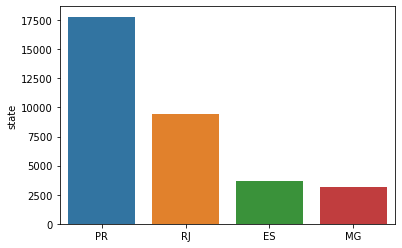

In [ ]:
'''
Com esse gráfico de barras podemos perceber que dos 8 estados presentes na amostra,
apenas 4 deles possuem contas fraudulentas. Percebemos também que desses 4 estados,
a maior concentração está no estado do Paraná e depois no Rio de Janeiro. 
'''


sns.barplot(x=data_fraudi.state.value_counts().index, y=data_fraudi.state.value_counts(), data=df)

<AxesSubplot:ylabel='occupation'>

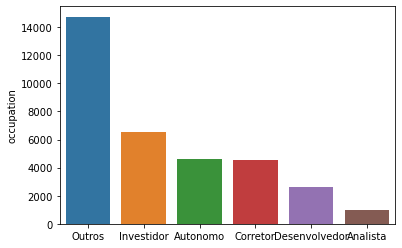

In [ ]:
'''
Com esse gráfico verificamos que a maioria das contas fraudulentas se identificam com a ocupação
profissional de 'Outros'.
'''

sns.barplot(x = data_fraudi.occupation.value_counts().index, 
            y = data_fraudi.occupation.value_counts(), data = df)

<BarContainer object of 4 artists>

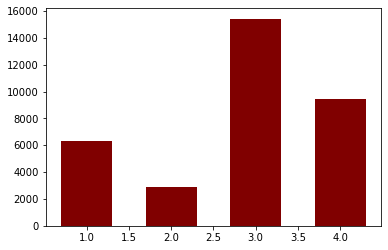

In [ ]:
'''
Ja nesse gráfico podemos perceber que as contas fraudulentas tiveram uma maior frequencia de
movimentação por recebimento de pix (tipo 3). Nota-se também um número elevado de boletos que foram 
gerados mas não foram pagos (tipo 4), nivel superior até do que os boletos que foram gerados
e foram pagos (tipo 1).  
'''

plt.bar(data_fraudi.transaction.value_counts().index, data_fraudi.transaction.value_counts(),
        color = 'maroon', width = 0.6)

<BarContainer object of 4 artists>

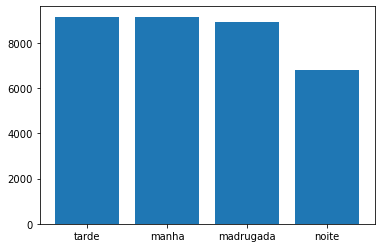

In [ ]:
'''
De acordo com esse gráfico, não é possivel verificar uma preferencia de turno pelas contas fraudulentos 
para as transações. No entanto, no gráfico anterior verificamos que as transações do tipo 3 
(pix recebido) são as mais frequentes. Para isso, criaremos novamente esse gráfico de turno, mas agora
filtrado apenas para as transações do tipo 3. 
'''

plt.bar(data_fraudi['shift'].value_counts().index, data_fraudi['shift'].value_counts())

<BarContainer object of 4 artists>

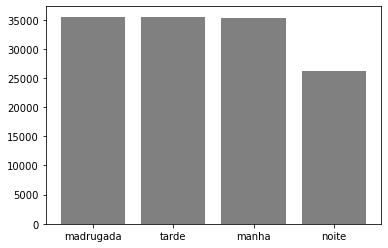

In [ ]:
'''
Com essa nova analise, podemos perceber que aparentemente não parece haver uma preferência de 
turno para as transações fraudulentas em relação a sua frequência. 
'''

data_fraudi_pix_recebi = df.loc[df['transaction'] == 3]
plt.bar(data_fraudi_pix_recebi['shift'].value_counts().index,
        data_fraudi_pix_recebi['shift'].value_counts(), color = 'grey')
       

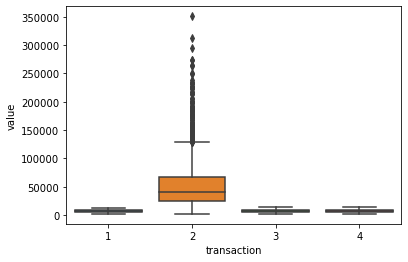

In [ ]:
'''
Agora analisando o valor das transações de contas fraudulentas para cada tipo, é possivel 
perceber que as do tipo 2 (Pix enviado), são as que possuem maiores valores de transação. 
Uma hipótese intuitiva é de que os fraldadores estejam enviando esses pix para suas outras contas 
ou contas de terceiros, por isso a discrepância. 
'''
ax = sns.boxplot(x="transaction", y="value", data=data_fraudi)

<BarContainer object of 4 artists>

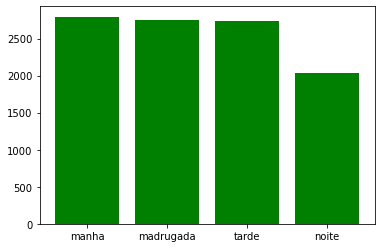

In [ ]:
'''
Dessa vez visualizando se os pix enviados (tipo 2) tem alguma preferencia por turnos, percebemos também
que aparentemente não tem. 
'''
data_fraudi_pix_env = df.loc[df['transaction'] == 2]
plt.bar(data_fraudi_pix_env['shift'].value_counts().index, data_fraudi_pix_env['shift'].value_counts(),
        color = 'green')

## Encoding
Para o encoding optamos por retirarmos a feature 'city' e usarmos somente a 'UF' para localidade das contas. Dessa forma, deixando o modelo mais simples.

In [ ]:
'''
retirando as variaveis'city' e 'trasaction_hour'
'''
df.drop(['city','trasaction_hour'], axis = 1, inplace = True)


In [ ]:
'''
salvando uma copia em 'auxi' para realizarmos o encoding
'''
auxi = df.copy()

In [ ]:
'''
Retirando o 'account_number' pois não é uma variavel explicativa para o modelo e sim um identificador
'''
auxi.drop(['account_number'], axis = 1, inplace = True)

In [ ]:
auxi.head()

,occupation,state,level,age,transaction,value,shift
0,Corretor,GO,0,51,4,8368.0,noite
1,Corretor,GO,0,51,1,8797.0,noite
2,Corretor,GO,0,51,1,8270.0,noite
3,Corretor,GO,0,51,3,7112.0,madrugada
4,Corretor,GO,0,51,3,8604.0,tarde


### One-Hot Encoder

In [ ]:
'''
codificando as varíaveis categóricas com o onehotencoder e vericando o tipo delas após a transformação
'''

one_hot_enc = OneHotEncoder(cols = ['state', 'transaction','occupation','shift'])
auxi = one_hot_enc.fit_transform(auxi)
auxi['level'] = auxi['level'].astype('int')
auxi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280629 entries, 0 to 314057
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   occupation_1   280629 non-null  int64  
 1   occupation_2   280629 non-null  int64  
 2   occupation_3   280629 non-null  int64  
 3   occupation_4   280629 non-null  int64  
 4   occupation_5   280629 non-null  int64  
 5   occupation_6   280629 non-null  int64  
 6   state_1        280629 non-null  int64  
 7   state_2        280629 non-null  int64  
 8   state_3        280629 non-null  int64  
 9   state_4        280629 non-null  int64  
 10  state_5        280629 non-null  int64  
 11  state_6        280629 non-null  int64  
 12  state_7        280629 non-null  int64  
 13  state_8        280629 non-null  int64  
 14  level          280629 non-null  int32  
 15  age            280629 non-null  int64  
 16  transaction_1  280629 non-null  int64  
 17  transaction_2  280629 non-nul

In [ ]:
'''
salvando uma copia do dataframe codificado 
'''
df_encode = auxi.copy()

# Model

In [ ]:
'''
Explorando as correlações com a variável resposta
'''

auxi.corr()['level'].sort_values(ascending = False)

level            1.000000
state_4          0.339709
occupation_2     0.309430
occupation_4     0.152514
state_3          0.118692
occupation_5     0.117237
transaction_4    0.096332
transaction_1    0.088293
value            0.027991
shift_1          0.002111
shift_4          0.001594
shift_3          0.000650
shift_2         -0.004143
transaction_3   -0.014587
state_7         -0.015029
occupation_1    -0.079837
state_1         -0.083081
state_5         -0.085342
state_6         -0.090020
state_8         -0.090929
transaction_2   -0.097784
occupation_3    -0.150046
age             -0.159767
occupation_6    -0.181572
state_2         -0.190615
Name: level, dtype: float64

In [ ]:
'''
Explorando a correlação entre todas as variáveis
'''
auxi.corr()

,occupation_1,occupation_2,occupation_3,occupation_4,occupation_5,occupation_6,state_1,state_2,state_3,state_4,...,age,transaction_1,transaction_2,transaction_3,transaction_4,value,shift_1,shift_2,shift_3,shift_4
occupation_1,1.000000,-0.217828,-0.310890,-0.120483,-0.176329,-0.298064,-0.060641,-0.029794,0.018761,-0.014419,...,0.047388,0.010279,-0.010360,0.003413,-0.004849,-0.006339,0.000435,0.003358,-0.003370,-0.000375
occupation_2,-0.217828,1.000000,-0.236447,-0.091633,-0.134106,-0.226692,-0.070511,-0.095333,-0.009175,0.131250,...,-0.075229,0.021467,-0.016037,-0.011605,0.025844,0.007192,0.004030,-0.003397,-0.002798,0.002573
occupation_3,-0.310890,-0.236447,1.000000,-0.130781,-0.191400,-0.323541,0.107773,0.071330,-0.018191,-0.047263,...,0.023554,-0.011871,0.028319,-0.011019,-0.015686,-0.008775,-0.000679,0.000772,0.002415,-0.002580
occupation_4,-0.120483,-0.091633,-0.130781,1.000000,-0.074175,-0.125385,0.011470,-0.069969,-0.015760,0.053304,...,-0.068138,0.006900,-0.018497,0.007193,0.012014,0.005692,0.000745,-0.002362,0.002658,-0.000971
occupation_5,-0.176329,-0.134106,-0.191400,-0.074175,1.000000,-0.183504,-0.042616,0.041913,-0.008662,0.042866,...,0.003386,-0.010524,-0.024894,0.025901,0.013949,0.011684,-0.001438,0.000639,-0.003858,0.004520
occupation_6,-0.298064,-0.226692,-0.323541,-0.125385,-0.183504,1.000000,0.031162,0.040547,0.021763,-0.102247,...,0.023329,-0.011684,0.021105,-0.004284,-0.016265,-0.001776,-0.002413,-0.000541,0.004487,-0.001781
state_1,-0.060641,-0.070511,0.107773,0.011470,-0.042616,0.031162,1.000000,-0.158114,-0.097769,-0.102952,...,0.060015,-0.004077,0.011775,-0.005050,-0.007049,0.001180,-0.000125,0.001704,0.000677,-0.002271
state_2,-0.029794,-0.095333,0.071330,-0.069969,0.041913,0.040547,-0.158114,1.000000,-0.309401,-0.325801,...,0.074572,-0.010615,0.009201,0.007241,-0.019876,0.006452,-0.000774,0.001396,-0.000398,-0.000301
state_3,0.018761,-0.009175,-0.018191,-0.015760,-0.008662,0.021763,-0.097769,-0.309401,1.000000,-0.201458,...,-0.086506,0.011179,-0.018693,0.004167,0.011706,0.005502,-0.000106,-0.000243,-0.000091,0.000430
state_4,-0.014419,0.131250,-0.047263,0.053304,0.042866,-0.102247,-0.102952,-0.325801,-0.201458,1.000000,...,-0.037989,0.034497,-0.033135,-0.007652,0.030399,-0.000476,-0.000005,-0.001889,0.000069,0.001825


<AxesSubplot:xlabel='level', ylabel='count'>

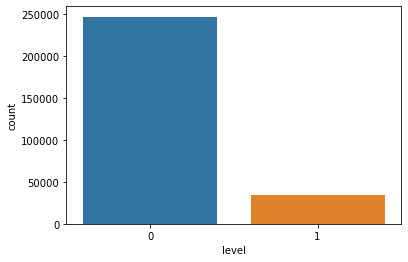

In [ ]:
'''
Verificando o balanceamento da variável level. Há um forte desbalanceamento.

Para que o modelo seja bem ajustado é preciso que a variável de interesse esteja bem balanceada
'''

auxi['level'].value_counts()
sns.countplot(auxi['level'])

In [ ]:
'''
Separando as variáveis explicativas da variável resposta
'''
X = auxi.drop('level', axis = 1)
y = auxi['level']

In [ ]:
'''
Balanceando nossa variável 'level'
'''
smt = SMOTE()
X, y = smt.fit_resample(X,y)

In [ ]:
'''
Nova contagem para variável resposta após o balanceamento 
'''
yi = y.astype(int)
np.bincount(yi)

array([246566, 246566], dtype=int64)

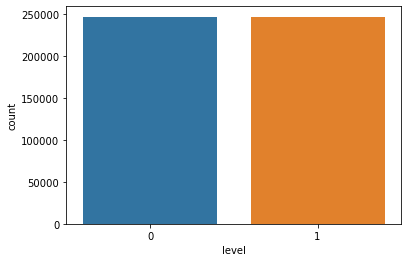

In [ ]:
'''
Com esse gráfico fica evidente que agora a varíavel "level" está balanceada 
'''

ax = sns.countplot(x = yi)

In [ ]:
'''
Separando dados de treino e dados de teste
'''

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 8,stratify = y)

# Criando os Modelos 

## XGBoost

In [ ]:
model_1 = XGBClassifier()

In [ ]:
'''
Treinando o modelo
'''

model_1 = model_1.fit(X_train, y_train)
model_1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
y_predict_1 = model_1.predict(X_val)

In [ ]:
'''
Comparando gabarito e Previsoes
'''
gabarito = pd.DataFrame({'Gabarito': y_val,
                         'Previsoes_XGBoost': y_predict_1})
gabarito

,Gabarito,Previsoes_XGBoost
275144,0,0
272518,0,0
299765,1,1
476823,1,1
280765,1,1
...,...,...
274201,0,0
327147,1,1
134306,0,0
209993,0,0


In [ ]:
'''
Verificando Métricas
'''


print('Classification metrics: \n', classification_report(y_val, y_predict_1))
print('Acurácia: \n', accuracy_score(y_val,y_predict_1)) 
print('Confusion Matrix: \n', confusion_matrix(y_val, y_predict_1))

Classification metrics: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     49313
           1       1.00      0.99      0.99     49314

    accuracy                           0.99     98627
   macro avg       0.99      0.99      0.99     98627
weighted avg       0.99      0.99      0.99     98627

Acurácia: 
 0.9945552434931612
Confusion Matrix: 
 [[49077   236]
 [  301 49013]]


## Random Forest

In [ ]:
model_2 = RandomForestClassifier()

In [ ]:
model_2 = model_2.fit(X_train, y_train)
model_2

RandomForestClassifier()

In [ ]:
y_predict_2 = model_2.predict(X_val)

In [ ]:
gabarito = pd.DataFrame({'Gabarito': y_val, 'Previsoes_Random_Forest': y_predict_2})
gabarito

,Gabarito,Previsoes_Random_Forest
275144,0,0
272518,0,0
299765,1,1
476823,1,1
280765,1,1
...,...,...
274201,0,0
327147,1,1
134306,0,0
209993,0,0


In [ ]:
print('Classification metrics: \n', classification_report(y_val, y_predict_2))
print('Acurácia: \n', accuracy_score(y_val, y_predict_2))
print('Confusion Matrix: \n', confusion_matrix(y_val, y_predict_2))

Classification metrics: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     49313
           1       0.99      0.99      0.99     49314

    accuracy                           0.99     98627
   macro avg       0.99      0.99      0.99     98627
weighted avg       0.99      0.99      0.99     98627

Acurácia: 
 0.9928315775598974
Confusion Matrix: 
 [[48964   349]
 [  358 48956]]


# Corss Validation

### Validando XGboots

In [ ]:
scores_XG = cross_val_score(model_1, X, y, cv = 5, scoring = 'accuracy')

In [ ]:
scores_XG

array([0.91389782, 0.97304998, 0.93100197, 0.90899966, 0.97885953])

In [ ]:
'''
Realizando o cross validation podemos perceber que, enquanto a acurácia estava dando 99% antes, agora
ja temos uma medida mais confiavel de 94%.
'''
scores_XG.mean()

0.9411617890864615

In [ ]:
'''
Uma outra boa métrica para se olhar é a mediana
'''

statistics.median(scores_XG)

0.9310019670269503

### Validando Random Forest 

In [ ]:
scores_RF = cross_val_score(model_2, X, y, cv = 5, scoring = 'accuracy')

In [ ]:
scores_RF

array([0.8875967 , 0.97393209, 0.93423641, 0.91221382, 0.97707501])

In [ ]:
'''
Realizando o cross validation podemos perceber que, enquanto a acurácia estava dando 99% antes, agora
ja temos uma medida mais confiavel de 93,70% em média.
'''

scores_RF.mean()

0.9370108054087354

In [ ]:
'''
Mediana
'''
statistics.median(scores_RF)

0.9310019670269503

## Escolha do melhor modelo

Tendo em vista que ao realizar o cross validation o XGBoost teve em média 94,12% e mediana de 93,10% de acurácia enquanto o Random Forest teve uma média de 93,70% e uma mediana de 93,10%, apesar de ambos terem bons resultados, optamos pelo XGBoost pela sua maior acertividade e velocidade de processamento. 


Lembrando que escolhemos a acurácia como métrica por ser a mais usualmente utilizada, mas a escolha deve ser tomada juntamente com a equipe de negócios para saber qual erro devemos priorizar a redução (Falso Positivo ou Falso Negativo).

### Criando csv para classificar as contas pendentes de classificação

In [ ]:
df_NA['trasaction_hour'] = pd.to_datetime(df_NA['created_at']).dt.hour
df_NA.drop(['created_at'], axis = 1, inplace = True)

df_NA.loc[(df_NA['trasaction_hour'] >= 0) & (df_NA['trasaction_hour'] < 7),'shift'] = 'madrugada'
df_NA.loc[(df_NA['trasaction_hour'] >= 7) & (df_NA['trasaction_hour'] < 13),'shift'] = 'manha'
df_NA.loc[(df_NA['trasaction_hour'] >= 13) & (df_NA['trasaction_hour'] < 19),'shift'] = 'tarde'
df_NA.loc[(df_NA['trasaction_hour'] >= 19) & (df_NA['trasaction_hour'] <= 23),'shift'] = 'noite'

In [ ]:
df_NA.drop(['city','trasaction_hour', 'account_number','level'], axis = 1, inplace = True)

In [ ]:
one_hot_enc = OneHotEncoder(cols = ['state', 'transaction','occupation','shift'])
df_NA = one_hot_enc.fit_transform(df_NA)

In [ ]:
df_NA.drop(['transaction_5','shift_5'], inplace = True, axis = 1)

In [ ]:
fraud = model_1.predict(df_NA)

In [ ]:
final_product = pd.DataFrame({
    'account_number' : account_number_NA,
    'fraud' : fraud
})

In [ ]:
final_product = final_product.groupby(by = ['account_number']).mean()

O modelo não é 100% acertivo e analisamos varios registros de cada usuário. Dessa
forma, apesar das métricas do modelo serem boas, temos alguns erros. Com isso, existem usuários que em 
alguns registros foram classificados como 0 e um ou outro como 1. 
Para minimizarmos esse erro na hora de classificar o usuário em específico, foi realizado
um agrupamento pela coluna 'account_number' e calculamos a média para cada um dos usuários.
Se acaso o usuário tiver uma média em 'fraud' maior que 0.5 então concluimos que é uma conta 
fraudulenta. 

In [ ]:
t = list(final_product['fraud'])
for i in range(0,102):
    if t[i] >= .5:
        t[i] = 1
    else:
        t[i] = 0
final_product['fraud'] = t

In [ ]:
final_product.value_counts()

fraud
0.0      90
1.0      13
dtype: int64

In [ ]:
final_product.to_csv("fraud_prediction.csv")